## Import Libraries

In [2]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier


from sklearn import metrics

%matplotlib inline

In [96]:
# Clasifiction + Decision Tree

## Load the Data

In [3]:
df = pd.read_csv("H_player.csv")

In [6]:
df.shape

(4840, 19)

In [8]:
df.head(2)

,Unnamed: 0,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value
0,0,Manchester United,Goalkeeper,189.0,32.0,104,0.00000,0.00000,0.009585,0.0,0.0,1.217252,0.335463,9390,42,5,13,15000000,70000000
1,3,Manchester United,Defender Centre-Back,175.0,25.0,82,0.02809,0.05618,0.224719,0.0,0.0,0.000000,0.000000,6408,175,22,9,50000000,50000000


In [10]:
df.drop(columns='Unnamed: 0' , inplace = True)

## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [12]:
# uniqeness
df.drop_duplicates(inplace=True)
df[df.duplicated()]

,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value


In [14]:
# Completeness
df.isnull().sum()

team                   0
position               0
height                 0
age                    0
appearance             0
goals                  0
assists                0
yellow cards           0
second yellow cards    0
red cards              0
goals conceded         0
clean sheets           0
minutes played         0
days_injured           0
games_injured          0
award                  0
current_value          0
highest_value          0
dtype: int64

In [16]:
# Accurecy types
df.dtypes

team                    object
position                object
height                 float64
age                    float64
appearance               int64
goals                  float64
assists                float64
yellow cards           float64
second yellow cards    float64
red cards              float64
goals conceded         float64
clean sheets           float64
minutes played           int64
days_injured             int64
games_injured            int64
award                    int64
current_value            int64
highest_value            int64
dtype: object

In [18]:
c_col = [col for col in df.columns if df[col].dtype == "object"]
n_col = [col for col in df.columns if df[col].dtype != "object"]

In [20]:
for i in c_col:
    print(df[i].value_counts())

team
Chelsea FC                      28
Manchester United               26
AZ Alkmaar                      26
Liverpool FC                    25
AC Monza                        25
                                ..
Club Estudiantes de La Plata     1
Defensa y Justicia               1
Club Athletico Paranaense        1
Club Atlético Tigre              1
Ulsan Hyundai                    1
Name: count, Length: 335, dtype: int64
position
Defender Centre-Back          955
Attack Centre-Forward         584
midfield-CentralMidfield      581
Goalkeeper                    442
midfield-DefensiveMidfield    432
Defender Right-Back           431
Defender Left-Back            399
midfield-AttackingMidfield    321
Attack-RightWinger            311
Attack-LeftWinger             285
midfield-RightMidfield         38
midfield-LeftMidfield          33
Attack-SecondStriker           25
Attack                          1
Defender                        1
midfield                        1
Name: count, dtype

In [22]:
# Calculate the price
price_35 = df['current_value'].quantile(0.35)
price_75 = df['current_value'].quantile(0.75)

# Function to categorize prices
def c_price(price):
    if price > price_75:
        return 'Expensive'
    elif price < price_35:
        return 'Cheap'
    else:
        return 'Good'

df['sale_price_category'] = df['current_value'].apply(c_price)
df.drop('current_value', axis=1, inplace=True)
print(df['sale_price_category'].value_counts())

sale_price_category
Good         2043
Cheap        1603
Expensive    1194
Name: count, dtype: int64


#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [77]:
df.head(2)

,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,highest_value,sale_price_category
0,Manchester United,Goalkeeper,189.0,32.0,104,0.00000,0.00000,0.009585,0.0,0.0,1.217252,0.335463,9390,42,5,13,70000000,Expensive
1,Manchester United,Defender Centre-Back,175.0,25.0,82,0.02809,0.05618,0.224719,0.0,0.0,0.000000,0.000000,6408,175,22,9,50000000,Expensive


In [24]:
c_col = ['team' , 'position']

In [26]:
# one hot coding
df = pd.get_dummies(df, columns=c_col)

In [28]:
df.shape

(4840, 367)

In [30]:
encoder = LabelEncoder()
df['sale_price_category'] = encoder.fit_transform(df['sale_price_category'])  

#### 3. Feature selection

In [16]:
# sns.heatmap(df.corr(), annot=True);

In [32]:
correlation = df.corr()
correlation['sale_price_category'].sort_values(ascending=False)

sale_price_category    1.000000
appearance             0.234790
minutes played         0.153808
games_injured          0.110557
assists                0.101354
                         ...   
position_Goalkeeper   -0.080753
team_Torpedo Moscow   -0.081412
team_SCR Altach       -0.081412
goals conceded        -0.082733
team_SV Ried          -0.087332
Name: sale_price_category, Length: 367, dtype: float64

In [34]:
# Set the correlation threshold
threshold = 0.1  # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['sale_price_category']) > threshold]['sale_price_category'].index
selected_features

Index(['appearance', 'assists', 'minutes played', 'games_injured',
       'sale_price_category'],
      dtype='object')

In [36]:
df =df[selected_features]

#### 4. Prepare train and test data

In [38]:
# Prepare data
X = df.drop(['sale_price_category'], axis=1)
y = df['sale_price_category']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)

# sacle the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [40]:
X.shape

(4840, 4)

## Buliding the Model

In [42]:
model = KNeighborsClassifier()

In [44]:
param_grid = {
    'n_neighbors': [2, 3, 4, 5, 6, 7]
}
grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='f1_macro', 
                           verbose=1)

## Train the Model

In [46]:
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7]}, scoring='f1_macro',
             verbose=1)

In [48]:
grid_search.best_params_

{'n_neighbors': 7}

In [50]:
model = grid_search.best_estimator_


## Test the Model

In [52]:
# Predict and evaluate the model
y_pred = model.predict(X_test_scaled)

## Evaluating the Model 

In [54]:
# our benchmark model
base_model = round(df['sale_price_category'].value_counts()[1]/df.shape[0]*100, 2)
base_model

24.67

1. Accuracy

In [58]:
# Evaluate the model
accuracy_test = accuracy_score(y_test, y_pred)
print('Test accuracy' ,accuracy_test*100)

Test accuracy 48.03719008264463


In [60]:
y_pred_train = model.predict(X_train_scaled)
accuracy_train = accuracy_score(y_train, y_pred_train)
print('Train accuracy' ,accuracy_train*100)

Train accuracy 62.603305785123965


2. Precision

In [62]:
# Calculate Precision
precision_test = precision_score(y_test, y_pred, average='macro')
print(f"Test Precision: {precision_test:.2f}")

Test Precision: 0.48


In [64]:
y_pred_train = model.predict(X_train_scaled)
precision_train = precision_score(y_train, y_pred_train,average='macro')
print(f"Train Precision: {precision_train:.2f}")

Train Precision: 0.63


3. Recall

In [66]:
# Calculate Recall
recall_test = recall_score(y_test, y_pred, average='macro')
print(f"Test Recall: {recall_test:.2f}")

Test Recall: 0.49


In [68]:
y_pred_train = model.predict(X_train_scaled)
recall_train = recall_score(y_train, y_pred_train, average='macro')
print(f"Train Recall: {recall_train:.2f}")

Train Recall: 0.62


4. F1 Score

In [70]:
# Calculate F1 Score
f1_test = f1_score(y_test, y_pred, average='macro')
print(f"Test F1 Score: {f1_test:.2f}")

Test F1 Score: 0.48


In [72]:
y_pred_train = model.predict(X_train_scaled)
f1_train = f1_score(y_train, y_pred_train, average='macro')
print(f"Train F1 Score: {f1_train:.2f}")

Train F1 Score: 0.62


#### Predictions vs. Real Values

In [74]:
predictions = model.predict(X_test_scaled)

In [76]:
Real_Values = np.array(y_test)
#Real_Values

#### Residual Histogram

In [78]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[181,  20, 111],
       [ 38, 117,  95],
       [145,  94, 167]])

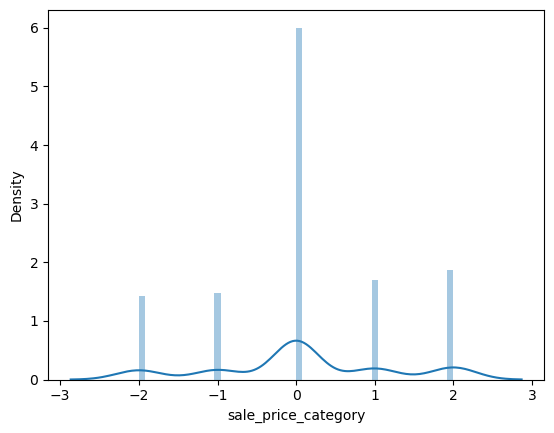

In [80]:
sns.distplot((y_test-predictions),bins=50); # it's good if we get normal distribution